In [1]:
import sys
sys.path.append("../")
import numpy as np
from scipy.fftpack import fftfreq
import os
import glob
import cv2
import csv
from utils import show_peak, VarianceFilter, FFTStrip,FFTSpaceStrip, doubleplot, doFilterFFT,tripleplot, VelocityStrip, watershed_image_hough,DiffVelocityStrip
import pandas as pd
from tifffile import imread, imwrite
from scipy.fftpack import fft
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
from skimage.morphology import remove_small_objects, binary_erosion

from scipy.signal import find_peaks
from skimage import data, io

from skimage.filters import threshold_otsu, threshold_mean
from skimage.filters import roberts, sobel, scharr, prewitt, gaussian
try:
    from pathlib import Path
    Path().expanduser()
except (ImportError, AttributeError):
        from pathlib2 import Path

try:
        import tempfile
        tempfile.TemporaryDirectory
except (ImportError, AttributeError):
       from backports import tempfile

In [2]:
Kymo = '/Users/aimachine/DistanceMethodCurvature_Dpachys_controlTrackID1.tif'
Embryo = '/Users/aimachine/Dpachys_control.tif'
Csv = '/Users/aimachine/Co-ordinatesETrack_Dpachys_controlCellID01.txt'
savedir = '/Users/aimachine/'
Time_unit = 10
Xcalibration = 0.034
#Block size for averaged measurments
blocksize = 50
timeav = 30
# Skip the display points on the clock
displayskip = 2
#ignore the last few blocks 
ignorelast = 1
Path(savedir).mkdir(exist_ok = True)


In [3]:

AverageVelocity = []
Block = []
AverageFrequ = []
Frequency = []
ImageName = []
AnteriorList = []
PosteriorList = []

 
    
Kymoimage = imread(Kymo)
Embryoimage = imread(Embryo)
x, y, t, distance, perimeter, N, M = np.loadtxt(Csv, skiprows = 3, unpack=True)
Blockiter = int(len(x)/max(t))
print('Total Perimeter points on Kymo:', Blockiter)
Dictionary = []
for i in range(0, Blockiter):
    Dictionary.append([i, x[i], y[i]])



   



Total Perimeter points on Kymo: 2401


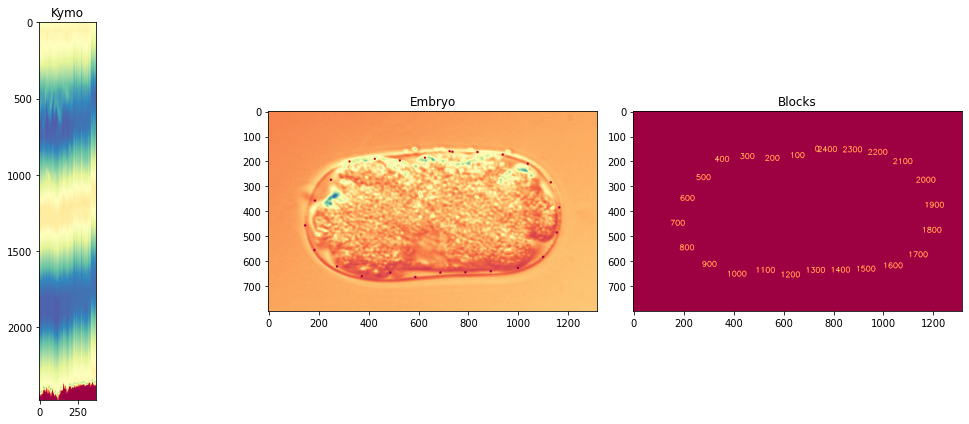

In [4]:
# font 
font = cv2.FONT_HERSHEY_SIMPLEX 
# org 
org = (50, 50) 
# fontScale 
fontScale = 1
 
color = (255, 255, 0) 
thickness = 1
Clock = np.zeros([Embryoimage.shape[1], Embryoimage.shape[2]])
for i in range(0, Blockiter, 2 *blocksize):
    cv2.circle(Embryoimage[0,:], (int(x[i]), int(y[i])), 5,(255,0,0), thickness = -1 )
    cv2.putText(Clock, str(i), (int(x[i]), int(y[i])), font,  
                   fontScale, color, thickness, cv2.LINE_AA)
tripleplot(Kymoimage,Embryoimage[0,:], Clock, 'Kymo', 'Embryo', 'Blocks')

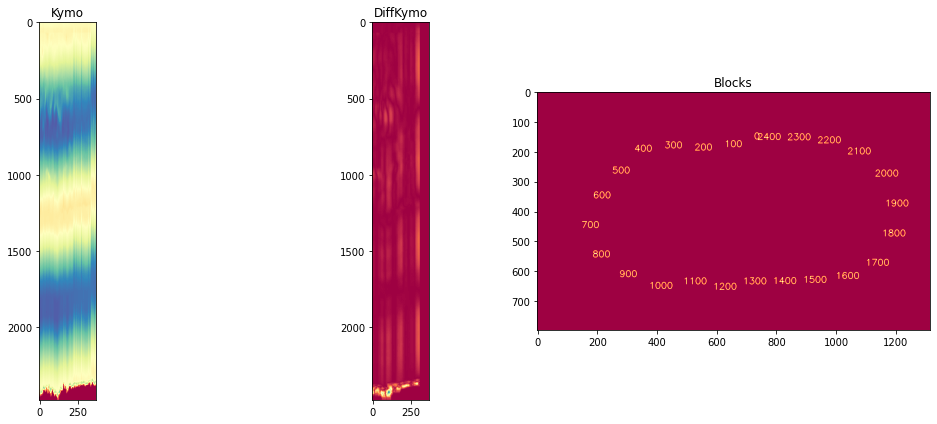

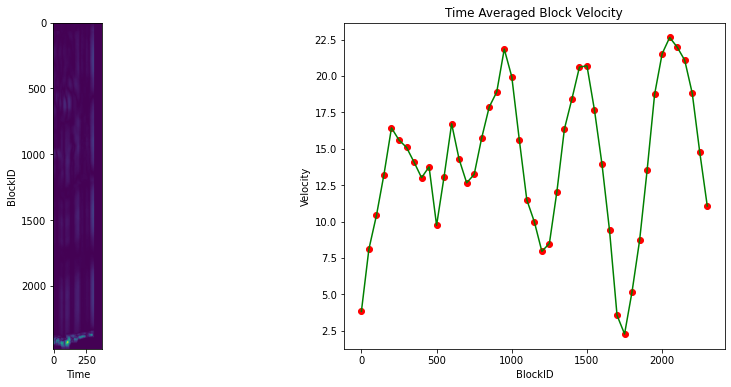

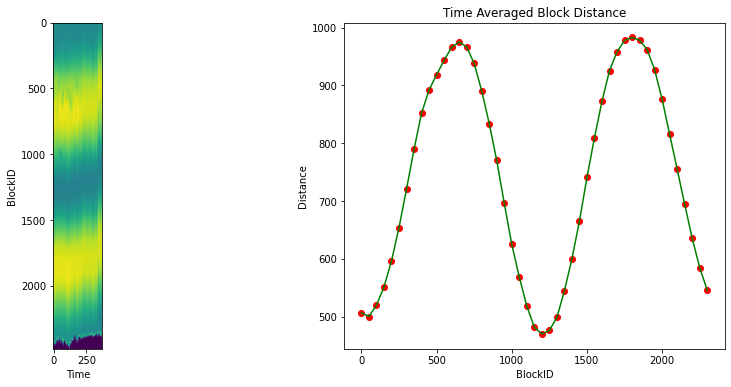

Anterior Part :  14.114472555552751 Posterior Part : 14.14003946603311


,Anterior Part,Posterior Part
0,14.114473,14.140039


In [5]:
Name = os.path.basename(os.path.splitext(Kymo)[0])

#Get simple velocity
FFTSpaceImage = FFTSpaceStrip(Kymoimage)
diffImage = VelocityStrip(Kymoimage,timeav,Xcalibration)
imwrite((savedir + Name + 'Diff' + '.tif' ) , diffImage.astype('float32'))
imwrite((savedir + Name + 'FFTSpace' + '.tif' ) , FFTSpaceImage.astype('float32'))
BlockVelocity = DiffVelocityStrip(diffImage, blocksize, Xcalibration)
BlockDistance = DiffVelocityStrip(Kymoimage, blocksize, Xcalibration)

tripleplot(Kymoimage,diffImage, Clock, 'Kymo', 'DiffKymo', 'Blocks')
IndexList = []
VelocityList = []
DistanceList = []
for i in range(0, len(BlockVelocity) - ignorelast):

    index, velocity = BlockVelocity[i]
    IndexList.append(index)
    VelocityList.append(velocity)
for i in range(0, len(BlockDistance) - ignorelast):

    index, distance = BlockDistance[i]
    DistanceList.append(distance)    
    
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
ax = axes.ravel()
ax[0].imshow(diffImage)
ax[0].set_xlabel('Time')
ax[0].set_ylabel('BlockID')
ax[1].plot(IndexList, VelocityList, 'ro')
ax[1].plot(IndexList, VelocityList, 'g')
ax[1].set_title('Time Averaged Block Velocity')
ax[1].set_xlabel('BlockID')
ax[1].set_ylabel('Velocity')
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(15, 6))
ax = axes.ravel()
ax[0].imshow(Kymoimage)
ax[0].set_xlabel('Time')
ax[0].set_ylabel('BlockID')
ax[1].plot(IndexList, DistanceList, 'ro')
ax[1].plot(IndexList, DistanceList, 'g')
ax[1].set_title('Time Averaged Block Distance')
ax[1].set_xlabel('BlockID')
ax[1].set_ylabel('Distance')
plt.show()
df = pd.DataFrame(list(zip(VelocityList,IndexList)), columns =['Velocity', 'BlockIndex'])
df.to_csv(savedir + Name + "SimpleVelocity"  '.csv', index = False)  

Anterior =    VelocityList[:len(VelocityList)//2]
Posterior = VelocityList[len(VelocityList)//2:]
AnteriorList.append(np.mean(Anterior))
PosteriorList.append(np.mean(Posterior))
print('Anterior Part : ', np.mean(Anterior), 'Posterior Part :', np.mean(Posterior))
df = pd.DataFrame(list(zip(AnteriorList,PosteriorList)), columns =['Anterior Part', 'Posterior Part'])
df.to_csv(savedir + Name + "AnteriorPosterior"  '.csv', index = False)   
df